In [52]:
import time
import pandas as pd
import polars as pl
import sys, os
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path
from pybit.unified_trading import HTTP
import xgboost as xgb
from sklearn.model_selection import train_test_split
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import matplotlib.pyplot as plt
import plotly.express as px
cfg = fin_utilities.__cfg_reading("pred")


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']

BYBIT_API_KEY = "5u0HfwB5UPJeiQo3WR"
BYBIT_SECRET_KEY = "hjFn5aEvyuVEZ1dnna6R4s1NS1vw3vZdJFIL"

In [232]:
def get_last_timestamp(df: pl.DataFrame):
    return df.get_column("timestamp")[-1]


def format_data(response):    
    data = response.get('list', None)
    if not data:
        return

    data = pl.DataFrame(data, schema={
        'timestamp': pl.Int64,
        'open': pl.Float64,
        'high': pl.Float64,
        'low': pl.Float64,
        'close': pl.Float64,
        'volume': pl.Float64,
        'turnover': pl.Float64,
    }, orient="row")
    
    # Reverse the DataFrame
    data = data.reverse()
    
    # Convert timestamp to datetime
    data = data.with_columns((pl.col('timestamp') * 1000).cast(pl.Datetime).alias('date'))
    
    return data


def get_data_from(
    category: str,
    symbol: str,
    start: int,
    end: int = None,
    interval: int = 60,
):
    df = pl.DataFrame()
    while True:
        response = session.get_kline(category=category, 
                                    symbol=symbol, 
                                    start=start,
                                    interval=interval).get('result')
        
        latest = format_data(response)
        if latest is None or latest.shape[0] == 0:
            break
        
        
        if end is not None and latest.select(pl.col('timestamp').cast(pl.Int64)).to_series().max() > end:
            df = df.filter(pl.col('timestamp').cast(pl.Int64) <= int(end))
            break
        
        start = get_last_timestamp(latest)
        time.sleep(0.1)
        
        df = pl.concat([df, latest])
        print(f'Collecting data starting {dt.datetime.fromtimestamp(start / 1000)}')
        if len(latest) == 1:
            break

    df = df.unique(subset=['timestamp'], keep='last')

    return df.sort("date")


def return_index_if_exists(df_series, curr_idx, val, pos_crit, max_length):
    # Slicing the series from curr_idx + 1 to curr_idx + 1 + max_length
    future_series = df_series.slice(curr_idx + 1, max_length)
    # display(future_series)
    if pos_crit:
        indices = future_series.filter(future_series >= val).arg_min()
    else:
        indices = future_series.filter(future_series <= val).arg_min()

    # Return the relative index if condition met within max_length, else return max_length
    if indices is not None and indices < max_length:
        return indices + 1  # +1 because of slicing offset
    else:
        return max_length

def labelize_output_according_criterion2(
    df, 
    trade="long",
    threshold=0.01, 
    risk_reward_ratio=0.5, 
    max_trade_length=6,
    wrt='close', 
    hl=['high', 'low'],
):

    if trade == "long":
        df_ = df.with_columns([
            (pl.col(wrt) * (1 + threshold / risk_reward_ratio)).alias('TP'),
            (pl.col(wrt) * (1 - threshold)).alias('SL'),

        ])
        pos_crit = True
        neg_crit = False
    elif trade == "short":
        df_ = df.with_columns([
            (pl.col(wrt) * (1 - threshold / risk_reward_ratio)).alias('TP'),
            (pl.col(wrt) * (1 + threshold)).alias('SL'),

        ])
        pos_crit = False
        neg_crit = True

    min_above = []
    min_below = []


    for idx in range(len(df_)):
        # display(df_.slice(idx,1))
        TP = df_["TP"][idx]
        SL = df_["SL"][idx]
        
        if idx != len(df_) - 1:
            candidates_above_minima = [
                return_index_if_exists(
                    df_series=df_[v], 
                    curr_idx=idx,
                    val=TP, 
                    pos_crit=pos_crit, 
                    max_length=max_trade_length
                ) 
                for v in hl
            ]
            candidates_below_minima = [
                return_index_if_exists(
                    df_series=df_[v], 
                    curr_idx=idx,
                    val=SL, 
                    pos_crit=neg_crit, 
                    max_length=max_trade_length
                ) 
                for v in hl
            ]
            
            min_above.append(min(candidates_above_minima))
            min_below.append(min(candidates_below_minima))

        else:
            min_above.append(None)
            min_below.append(None)

    df_ = df_.with_columns(pl.Series('min_above', min_above))
    df_ = df_.with_columns(pl.Series('min_below', min_below))
    
    # Generate the signal
    signal = ((df_['min_above'] < df_['min_below']) & (df_['min_above'] <= max_trade_length)).cast(pl.Int8) * (1 if trade=="long" else -1)
    return signal

def split_target_features(
    df: pl.DataFrame,
    feat_to_exclude: list() = [],
    target_var: str = 'signal'
) -> [pl.DataFrame, pl.Series]:
    """
    Given a DataFrame, split df into features and target.

    Args:
        df: dataframe to be split
        feat_to_exclude: list of columns to exclude from features
        target_var: variable target

    Returns:
        Tuple[pl.DataFrame, pl.Series]: feature and target data
    """
    # Select columns that are not in feat_to_exclude and not the target_var
    features = df.select([col for col in df.columns if col not in (feat_to_exclude + [target_var])])
    labels = df.select([target_var])

    return features, labels


def scale_features(df, cols_list):
    if isinstance(cols_list, list):
        for col in cols_list:
            df = df.with_columns(df[col].pct_change().alias(f"{col}_pct_change"))
            df = df.with_columns(((df[col] - df[col].mean()) / df[col].std()).alias(f"{col}_z_score"))
    elif isinstance(cols_list, str):
        col = cols_list
        df = df.with_columns(df[col].pct_change().alias(f"{col}_pct_change"))
        df = df.with_columns(((df[col] - df[col].mean()) / df[col].std()).alias(f"{col}_z_score"))
    else:
        raise ValueError("cols_list must be a list or a string")
    
    return df

def plot_histogram(df, symbol, col, bins=100):
    series_to_plot = df.filter(pl.col("symbol") == symbol)[col]

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(series_to_plot, bins=bins, edgecolor='black')
    plt.title(f'Histogram of {symbol.upper()}, column {col}')
    plt.xlabel('Percentage Change')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Show the plot
    plt.show()

import polars as pl

def calculate_rsi(df: pl.DataFrame, column: str = "close", window: int = 14) -> pl.DataFrame:
    # Calculate price changes
    delta = df[column].diff()

    # Separate gains and losses
    gains = delta.clip(lower_bound=0)
    losses = -delta.clip(upper_bound=0)

    # Calculate EMAs for gains and losses
    alpha = 1 / window
    gains_ema = gains.ewm_mean(alpha=alpha)
    losses_ema = losses.ewm_mean(alpha=alpha)

    # Calculate RS and RSI
    rs = gains_ema / losses_ema
    rsi = 100 - (100 / (1 + rs)).round(2)

    # Add RSI to the DataFrame
    return df.with_columns(rsi.alias(f"RSI_{window}"))

In [132]:
session = HTTP(
    testnet=False,
    api_key=BYBIT_API_KEY,
    api_secret=BYBIT_SECRET_KEY,
)

In [133]:
print(dt.datetime.fromtimestamp(session.get_server_time()["time"]/1000).strftime('%Y-%m-%d %H:%M:%S'))


2024-09-21 00:13:19


In [134]:
# COPPIE DISPONIBILI
result = session.get_tickers(
    category="linear"
).get('result')['list']

tickers = [asset['symbol'] for asset in result if asset['symbol'].endswith('USDT')]
print(tickers)

['10000000AIDOGEUSDT', '1000000BABYDOGEUSDT', '1000000MOGUSDT', '1000000PEIPEIUSDT', '10000COQUSDT', '10000LADYSUSDT', '10000SATSUSDT', '10000WENUSDT', '1000APUUSDT', '1000BEERUSDT', '1000BONKUSDT', '1000BTTUSDT', '1000CATUSDT', '1000FLOKIUSDT', '1000LUNCUSDT', '1000NEIROCTOUSDT', '1000PEPEUSDT', '1000RATSUSDT', '1000TURBOUSDT', '1000XECUSDT', '1CATUSDT', '1INCHUSDT', 'A8USDT', 'AAVEUSDT', 'ACEUSDT', 'ACHUSDT', 'ADAUSDT', 'AERGOUSDT', 'AEROUSDT', 'AEVOUSDT', 'AGIUSDT', 'AGLDUSDT', 'AIOZUSDT', 'AIUSDT', 'AKROUSDT', 'AKTUSDT', 'ALEOUSDT', 'ALGOUSDT', 'ALICEUSDT', 'ALPACAUSDT', 'ALPHAUSDT', 'ALTUSDT', 'AMBUSDT', 'ANKRUSDT', 'APEUSDT', 'API3USDT', 'APTUSDT', 'ARBUSDT', 'ARKMUSDT', 'ARKUSDT', 'ARPAUSDT', 'ARUSDT', 'ASTRUSDT', 'ATAUSDT', 'ATHUSDT', 'ATOMUSDT', 'AUCTIONUSDT', 'AUDIOUSDT', 'AVAILUSDT', 'AVAXUSDT', 'AXLUSDT', 'AXSUSDT', 'BADGERUSDT', 'BAKEUSDT', 'BALUSDT', 'BANANAUSDT', 'BANDUSDT', 'BATUSDT', 'BBUSDT', 'BCHUSDT', 'BEAMUSDT', 'BELUSDT', 'BENDOGUSDT', 'BICOUSDT', 'BIGTIMEUSDT', '

In [151]:
start = int(dt.datetime(2024, 5, 1).timestamp()* 1000)
interval = 60
symbols_list = ["ETHUSDT" ] # , "BTCUSDT"]

df_orig = pl.DataFrame()
for symbol in symbols_list:
    print(f"Collecting data for {symbol}")
    tmp_df = get_data_from(
        category='spot',
        symbol=symbol,
        start=start,
        end=None,
        interval=interval,
    )
    tmp_df = tmp_df.with_columns(pl.lit(symbol.replace("USDT","")).alias("symbol"))
    tmp_df = tmp_df.with_columns(labelize_output_according_criterion2(tmp_df, "long").alias("long_signal"))
    tmp_df = tmp_df.with_columns(labelize_output_according_criterion2(tmp_df, "short").alias("short_signal"))

    df_orig = df_orig.vstack(tmp_df)

df_orig.tail()

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8
1726909200000,2548.94,2553.24,2545.94,2552.9,3312.20947,8.4467e6,2024-09-21 09:00:00,"""ETH""",0,0
1726912800000,2552.9,2553.38,2544.83,2546.64,2969.92107,7.5683e6,2024-09-21 10:00:00,"""ETH""",0,0
1726916400000,2546.64,2557.08,2545.4,2556.38,3218.74052,8.2110e6,2024-09-21 11:00:00,"""ETH""",0,0
1726920000000,2556.38,2562.23,2551.24,2561.9,2361.80296,6.0350e6,2024-09-21 12:00:00,"""ETH""",0,0
1726923600000,2561.9,2569.59,2556.13,2569.51,4678.85749,1.1992e7,2024-09-21 13:00:00,"""ETH""",null,null


In [152]:
fig = px.line(df_orig.select(pl.col(["date","close"])), x="date", y="close")
fig.show()
fig2 = px.line(df_orig.select(pl.col(["date","volume"])), x="date", y="volume")
fig2.show()
fig3 = px.line(df_orig.select(pl.col(["date","turnover"])), x="date", y="turnover")
fig3.show()

In [153]:
df_orig.select(pl.col(["close","volume", "turnover"])).corr()

close,volume,turnover
f64,f64,f64
1.0,-0.135113,0.041601
-0.135113,1.0,0.964098
0.041601,0.964098,1.0


In [233]:
df = df_orig
print(df.shape)

(3448, 11)


## SCALO FEATURE

In [234]:
# Create a list to store the processed dataframes
processed_dfs = []

for symbol in df["symbol"].unique():
    # Filter the dataframe for the current symbol
    tmp_df = df.filter(pl.col("symbol") == symbol)    
    # Apply scale_features to the filtered dataframe
    tmp_df = scale_features(tmp_df, ["close", "volume", "turnover"])
    # Append the processed dataframe to the list
    processed_dfs.append(tmp_df)

# Concatenate all processed dataframes
df = pl.concat(processed_dfs)

# Drop any null values that might have been introduced
df = df.drop_nulls()

# Display the first few rows of the updated dataframe
df.head()

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,close_z_score,volume_pct_change,volume_z_score,turnover_pct_change,turnover_z_score
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64
1714518000000,3009.93,3029.58,3000.16,3014.45,4579.56354,1.3801e7,2024-04-30 23:00:00,"""ETH""",0,0,0.001502,-0.135932,-0.452,-0.33918,-0.451243,-0.362584
1714521600000,3014.45,3023.45,2987.78,2999.44,8592.77697,2.5824e7,2024-05-01 00:00:00,"""ETH""",0,0,-0.004979,-0.167467,0.876331,0.255006,0.871205,0.268152
1714525200000,2999.44,3015.05,2978.3,3002.43,8487.78005,2.5470e7,2024-05-01 01:00:00,"""ETH""",0,-1,0.000997,-0.161186,-0.012219,0.23946,-0.013726,0.249557
1714528800000,3002.43,3004.12,2960.19,2987.19,8750.65698,2.6100e7,2024-05-01 02:00:00,"""ETH""",0,-1,-0.005076,-0.193204,0.030971,0.278381,0.024746,0.282621
1714532400000,2987.19,3008.27,2984.98,3004.12,3278.33515,9.8225e6,2024-05-01 03:00:00,"""ETH""",0,-1,0.005668,-0.157635,-0.625361,-0.531837,-0.62366,-0.571286


In [235]:
fig = px.line(df.select(pl.col(["date","close_pct_change"])), x="date", y="close_pct_change")
fig.show()
fig2 = px.line(df.select(pl.col(["date","volume_pct_change"])), x="date", y="volume_pct_change")
fig2.show()
fig3 = px.line(df.select(pl.col(["date","turnover_pct_change"])), x="date", y="turnover_pct_change")
fig3.show()

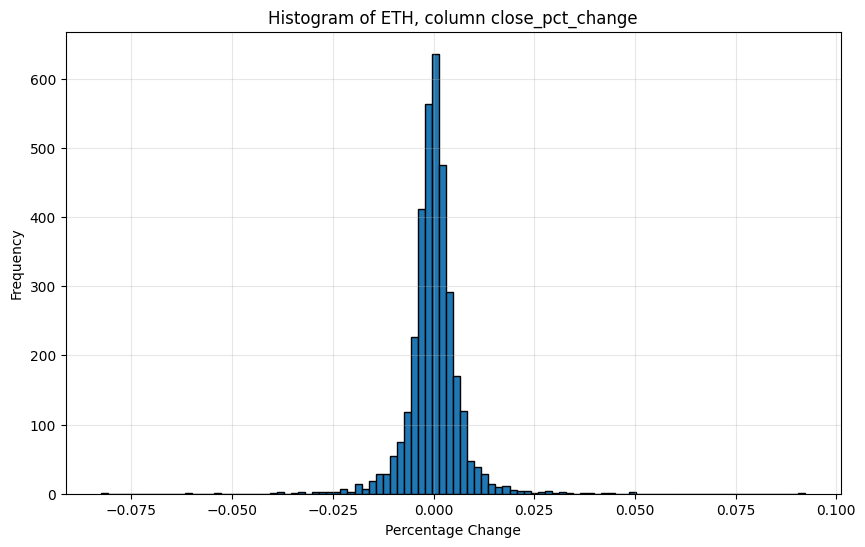

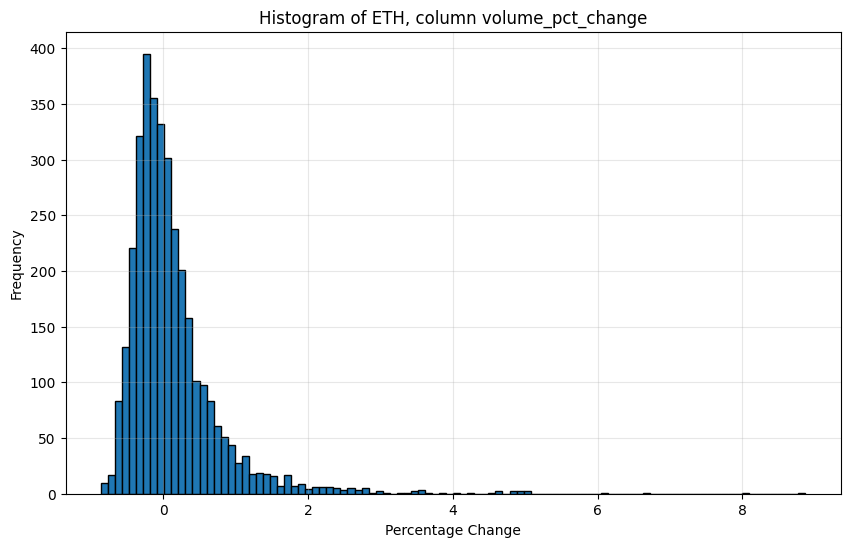

In [236]:
plot_histogram(df, "ETH", "close_pct_change")
plot_histogram(df, "ETH", "volume_pct_change")

In [237]:
df.head()

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,close_z_score,volume_pct_change,volume_z_score,turnover_pct_change,turnover_z_score
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64
1714518000000,3009.93,3029.58,3000.16,3014.45,4579.56354,1.3801e7,2024-04-30 23:00:00,"""ETH""",0,0,0.001502,-0.135932,-0.452,-0.33918,-0.451243,-0.362584
1714521600000,3014.45,3023.45,2987.78,2999.44,8592.77697,2.5824e7,2024-05-01 00:00:00,"""ETH""",0,0,-0.004979,-0.167467,0.876331,0.255006,0.871205,0.268152
1714525200000,2999.44,3015.05,2978.3,3002.43,8487.78005,2.5470e7,2024-05-01 01:00:00,"""ETH""",0,-1,0.000997,-0.161186,-0.012219,0.23946,-0.013726,0.249557
1714528800000,3002.43,3004.12,2960.19,2987.19,8750.65698,2.6100e7,2024-05-01 02:00:00,"""ETH""",0,-1,-0.005076,-0.193204,0.030971,0.278381,0.024746,0.282621
1714532400000,2987.19,3008.27,2984.98,3004.12,3278.33515,9.8225e6,2024-05-01 03:00:00,"""ETH""",0,-1,0.005668,-0.157635,-0.625361,-0.531837,-0.62366,-0.571286


# Creo Feature

In [238]:
def extract_date_features(df, date_col):
    df = df.with_columns(
        pl.col(date_col).dt.weekday().alias("dow"),
        pl.col(date_col).dt.month().alias("month"),
        pl.col(date_col).dt.hour().alias("hour"),
    )

    return df

moving_averages_list = [13, 50, 100, 200]
on_cols = ["close_pct_change","close"]

for window in moving_averages_list:
    for col in on_cols:
        df = df.with_columns(
            (pl.col(col).rolling_mean(window_size=window)).alias(f"SMA_{col}_{window}"),
        )

df = df.drop_nulls()
df = extract_date_features(df, "date")
df.head(5)


timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,close_z_score,volume_pct_change,volume_z_score,turnover_pct_change,turnover_z_score,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8
1715234400000,3004.02,3013.18,2997.36,3001.27,2677.73608,8.0464e6,2024-05-09 06:00:00,"""ETH""",0,0,-0.000915,-0.163623,-0.259205,-0.62076,-0.259401,-0.664458,-0.000249,2988.843846,-0.000411,3027.5092,-0.000248,3074.1742,0.000005,3045.3167,4,5,6
1715238000000,3001.27,3002.39,2975.8,2983.51,4260.19402,1.2740e7,2024-05-09 07:00:00,"""ETH""",0,0,-0.005917,-0.200935,0.590969,-0.386465,0.583272,-0.418254,-0.000653,2986.84,-0.000556,3025.786,-0.000326,3073.1391,-0.000032,3045.162,4,5,7
1715241600000,2983.51,2991.99,2975.14,2985.1,3399.38881,1.0145e7,2024-05-09 08:00:00,"""ETH""",0,0,0.000533,-0.197595,-0.202058,-0.513914,-0.2037,-0.554389,-0.00036,2985.718462,-0.000544,3024.098,-0.000327,3072.1008,-0.000004,3045.0903,4,5,8
1715245200000,2985.1,2987.19,2964.0,2982.71,5086.53416,1.5138e7,2024-05-09 09:00:00,"""ETH""",0,0,-0.000801,-0.202616,0.496308,-0.26412,0.492193,-0.292456,0.00081,2988.106923,-0.000613,3022.1974,-0.000325,3071.0709,-0.000013,3044.9917,4,5,9
1715248800000,2982.71,2984.47,2952.72,2955.24,4966.44591,1.4747e7,2024-05-09 10:00:00,"""ETH""",1,0,-0.00921,-0.260328,-0.023609,-0.281899,-0.02582,-0.312959,-0.000419,2986.846154,-0.00107,3018.9098,-0.000438,3069.7018,-0.000034,3044.83195,4,5,10


In [239]:
df.with_columns(scale_features(df, ["SMA_close_13"])["SMA_close_13_pct_change"].alias("SMA_close_pct_change_13_after_scaling"))

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,close_z_score,volume_pct_change,volume_z_score,turnover_pct_change,turnover_z_score,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,SMA_close_pct_change_13_after_scaling
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,f64
1715234400000,3004.02,3013.18,2997.36,3001.27,2677.73608,8.0464e6,2024-05-09 06:00:00,"""ETH""",0,0,-0.000915,-0.163623,-0.259205,-0.62076,-0.259401,-0.664458,-0.000249,2988.843846,-0.000411,3027.5092,-0.000248,3074.1742,0.000005,3045.3167,4,5,6,null
1715238000000,3001.27,3002.39,2975.8,2983.51,4260.19402,1.2740e7,2024-05-09 07:00:00,"""ETH""",0,0,-0.005917,-0.200935,0.590969,-0.386465,0.583272,-0.418254,-0.000653,2986.84,-0.000556,3025.786,-0.000326,3073.1391,-0.000032,3045.162,4,5,7,-0.00067
1715241600000,2983.51,2991.99,2975.14,2985.1,3399.38881,1.0145e7,2024-05-09 08:00:00,"""ETH""",0,0,0.000533,-0.197595,-0.202058,-0.513914,-0.2037,-0.554389,-0.00036,2985.718462,-0.000544,3024.098,-0.000327,3072.1008,-0.000004,3045.0903,4,5,8,-0.000375
1715245200000,2985.1,2987.19,2964.0,2982.71,5086.53416,1.5138e7,2024-05-09 09:00:00,"""ETH""",0,0,-0.000801,-0.202616,0.496308,-0.26412,0.492193,-0.292456,0.00081,2988.106923,-0.000613,3022.1974,-0.000325,3071.0709,-0.000013,3044.9917,4,5,9,0.0008
1715248800000,2982.71,2984.47,2952.72,2955.24,4966.44591,1.4747e7,2024-05-09 10:00:00,"""ETH""",1,0,-0.00921,-0.260328,-0.023609,-0.281899,-0.02582,-0.312959,-0.000419,2986.846154,-0.00107,3018.9098,-0.000438,3069.7018,-0.000034,3044.83195,4,5,10,-0.000422
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1726905600000,2555.47,2557.42,2548.06,2548.94,3104.39476,7.9232e6,2024-09-21 08:00:00,"""ETH""",0,0,-0.002555,-1.113935,-0.335322,-0.55759,-0.335504,-0.670922,0.000242,2548.615385,0.001079,2508.225,0.001093,2422.5537,0.000404,2395.2067,6,9,8,0.000236
1726909200000,2548.94,2553.24,2545.94,2552.9,3312.20947,8.4467e6,2024-09-21 09:00:00,"""ETH""",0,0,0.001554,-1.105616,0.066942,-0.526821,0.06608,-0.643456,0.000372,2549.547692,0.000937,2510.522,0.001052,2425.0633,0.000409,2396.17695,6,9,9,0.000366
1726912800000,2552.9,2553.38,2544.83,2546.64,2969.92107,7.5683e6,2024-09-21 10:00:00,"""ETH""",0,0,-0.002452,-1.118768,-0.103341,-0.5775,-0.103994,-0.689537,0.000034,2549.617692,0.000942,2512.8264,0.001039,2427.5353,0.000403,2397.1291,6,9,10,0.000027


In [240]:
df = df.with_columns(
    pl.when(pl.col("open") > pl.col("close")).then(1).otherwise(0).alias("green_candle"),
    pl.when(pl.col("open") <= pl.col("close")).then(1).otherwise(0).alias("red_candle")
)
# cumulative count of consecutive green candles set to True:

df = df.with_columns(
    pl.when(pl.col("green_candle") == 1)
    .then(
        pl.col("green_candle").cum_sum().over(
            (pl.col("green_candle") != pl.col("green_candle").shift(1)).cum_sum()
        ) - 1
    )
    .otherwise(0)
    .alias("cons_green_candles"),
    pl.when(pl.col("red_candle") == 1)
    .then(
        pl.col("red_candle").cum_sum().over(
            (pl.col("red_candle") != pl.col("red_candle").shift(1)).cum_sum()
        ) - 1
    )
    .otherwise(0)
    .alias("cons_red_candles")
)

In [241]:
df = calculate_rsi(df, window=14)
df.tail(10)

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,close_z_score,volume_pct_change,volume_z_score,turnover_pct_change,turnover_z_score,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,green_candle,red_candle,cons_green_candles,cons_red_candles,RSI_14
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i32,i32,i32,i32,f64
1726887600000,2542.1,2549.8,2541.02,2543.99,3833.91797,9.7634e6,2024-09-21 03:00:00,"""ETH""",0,0,0.000743,-1.124335,-0.198152,-0.449579,-0.196317,-0.574385,-0.000065,2548.185385,0.00126,2494.5358,0.001045,2409.2915,0.000387,2390.4453,6,9,3,0,1,0,0,55.73
1726891200000,2543.99,2545.72,2528.86,2537.6,6331.90238,1.6067e7,2024-09-21 04:00:00,"""ETH""",0,0,-0.002512,-1.13776,0.651549,-0.079734,0.645622,-0.24371,-0.000675,2546.447692,0.001129,2497.2802,0.00112,2411.9394,0.000394,2391.3738,6,9,4,1,0,0,0,53.03
1726894800000,2537.6,2545.87,2534.94,2544.68,4301.21136,1.0929e7,2024-09-21 05:00:00,"""ETH""",0,0,0.00279,-1.122885,-0.320708,-0.380392,-0.319758,-0.51322,-0.000084,2546.216923,0.001156,2500.0972,0.001136,2414.6321,0.000414,2392.35155,6,9,5,0,1,0,0,55.6
1726898400000,2544.68,2553.18,2542.73,2547.71,4238.4677,1.0806e7,2024-09-21 06:00:00,"""ETH""",0,0,0.001191,-1.11652,-0.014587,-0.389682,-0.011304,-0.519701,0.000331,2547.044615,0.001075,2502.7214,0.001097,2417.2396,0.000394,2393.28335,6,9,6,0,1,0,1,56.69
1726902000000,2547.71,2558.98,2547.34,2555.47,4670.52512,1.1924e7,2024-09-21 07:00:00,"""ETH""",0,0,0.003046,-1.100216,0.101937,-0.325713,0.103443,-0.461063,0.000386,2548.013846,0.001172,2505.5888,0.001141,2419.9543,0.000408,2394.25085,6,9,7,0,1,0,2,59.43
1726905600000,2555.47,2557.42,2548.06,2548.94,3104.39476,7.9232e6,2024-09-21 08:00:00,"""ETH""",0,0,-0.002555,-1.113935,-0.335322,-0.55759,-0.335504,-0.670922,0.000242,2548.615385,0.001079,2508.225,0.001093,2422.5537,0.000404,2395.2067,6,9,8,1,0,0,0,56.2
1726909200000,2548.94,2553.24,2545.94,2552.9,3312.20947,8.4467e6,2024-09-21 09:00:00,"""ETH""",0,0,0.001554,-1.105616,0.066942,-0.526821,0.06608,-0.643456,0.000372,2549.547692,0.000937,2510.522,0.001052,2425.0633,0.000409,2396.17695,6,9,9,0,1,0,0,57.7
1726912800000,2552.9,2553.38,2544.83,2546.64,2969.92107,7.5683e6,2024-09-21 10:00:00,"""ETH""",0,0,-0.002452,-1.118768,-0.103341,-0.5775,-0.103994,-0.689537,0.000034,2549.617692,0.000942,2512.8264,0.001039,2427.5353,0.000403,2397.1291,6,9,10,1,0,0,0,54.52
1726916400000,2546.64,2557.08,2545.4,2556.38,3218.74052,8.2110e6,2024-09-21 11:00:00,"""ETH""",0,0,0.003825,-1.098305,0.08378,-0.54066,0.084913,-0.655824,0.000171,2550.037692,0.001024,2515.337,0.001033,2430.005,0.000421,2398.12915,6,9,11,0,1,0,0,58.37


In [254]:
def calculate_macd(df: pl.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pl.DataFrame:
    # Calculate the short and long EMAs
    df = df.with_columns([
        pl.col("close").ewm_mean(span=short_window).alias("ema_short"),
        pl.col("close").ewm_mean(span=long_window).alias("ema_long")
    ])
    
    # Calculate MACD
    df = df.with_columns([
        (pl.col("ema_short") - pl.col("ema_long")).alias("MACD")
    ])
    
    # Calculate the signal line
    df = df.with_columns([
        pl.col("MACD").ewm_mean(span=signal_window).alias("signal_line")
    ])
    
    # Calculate the MACD histogram (MACD - Signal)
    df = df.with_columns([
        (pl.col("MACD") - pl.col("signal_line")).round(2).alias("macd_histogram")
    ])
    
    return df

def calculate_bollinger_bands(df: pl.DataFrame, window: int = 20, k: float = 2.0) -> pl.DataFrame:
    # Calculate rolling mean (SMA) and rolling standard deviation
    df = df.with_columns([
        pl.col("close").rolling_mean(window).alias("sma"),
        pl.col("close").rolling_std(window).alias("std_dev")
    ])
    
    # Calculate upper and lower bands
    df = df.with_columns([
        (pl.col("sma") + (k * pl.col("std_dev"))).alias("upper_band"),
        (pl.col("sma") - (k * pl.col("std_dev"))).alias("lower_band")
    ])
    
    return df

df = calculate_macd(df)
df = calculate_bollinger_bands(df)
df.tail(10)

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,close_z_score,volume_pct_change,volume_z_score,turnover_pct_change,turnover_z_score,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,green_candle,red_candle,cons_green_candles,cons_red_candles,RSI_14,ema_short,ema_long,MACD,signal_line,macd_histogram,sma,std_dev,upper_band,lower_band
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1726887600000,2542.1,2549.8,2541.02,2543.99,3833.91797,9.7634e6,2024-09-21 03:00:00,"""ETH""",0,0,0.000743,-1.124335,-0.198152,-0.449579,-0.196317,-0.574385,-0.000065,2548.185385,0.00126,2494.5358,0.001045,2409.2915,0.000387,2390.4453,6,9,3,0,1,0,0,55.73,2546.67577,2531.076475,15.599295,20.477438,-4.88,2547.208,9.191596,2565.591192,2528.824808
1726891200000,2543.99,2545.72,2528.86,2537.6,6331.90238,1.6067e7,2024-09-21 04:00:00,"""ETH""",0,0,-0.002512,-1.13776,0.651549,-0.079734,0.645622,-0.24371,-0.000675,2546.447692,0.001129,2497.2802,0.00112,2411.9394,0.000394,2391.3738,6,9,4,1,0,0,0,53.03,2545.279498,2531.559699,13.719799,19.12591,-5.41,2546.792,9.437933,2565.667866,2527.916134
1726894800000,2537.6,2545.87,2534.94,2544.68,4301.21136,1.0929e7,2024-09-21 05:00:00,"""ETH""",0,0,0.00279,-1.122885,-0.320708,-0.380392,-0.319758,-0.51322,-0.000084,2546.216923,0.001156,2500.0972,0.001136,2414.6321,0.000414,2392.35155,6,9,5,0,1,0,0,55.6,2545.187267,2532.531573,12.655694,17.831867,-5.18,2546.8755,9.410058,2565.695615,2528.055385
1726898400000,2544.68,2553.18,2542.73,2547.71,4238.4677,1.0806e7,2024-09-21 06:00:00,"""ETH""",0,0,0.001191,-1.11652,-0.014587,-0.389682,-0.011304,-0.519701,0.000331,2547.044615,0.001075,2502.7214,0.001097,2417.2396,0.000394,2393.28335,6,9,6,0,1,0,1,56.69,2545.57538,2533.655901,11.919479,16.649389,-4.73,2546.4885,9.195575,2564.87965,2528.09735
1726902000000,2547.71,2558.98,2547.34,2555.47,4670.52512,1.1924e7,2024-09-21 07:00:00,"""ETH""",0,0,0.003046,-1.100216,0.101937,-0.325713,0.103443,-0.461063,0.000386,2548.013846,0.001172,2505.5888,0.001141,2419.9543,0.000408,2394.25085,6,9,7,0,1,0,2,59.43,2547.097629,2535.27176,11.825869,15.684685,-3.86,2547.011,9.402307,2565.815614,2528.206386
1726905600000,2555.47,2557.42,2548.06,2548.94,3104.39476,7.9232e6,2024-09-21 08:00:00,"""ETH""",0,0,-0.002555,-1.113935,-0.335322,-0.55759,-0.335504,-0.670922,0.000242,2548.615385,0.001079,2508.225,0.001093,2422.5537,0.000404,2395.2067,6,9,8,1,0,0,0,56.2,2547.381071,2536.284222,11.096849,14.767118,-3.67,2546.75,9.264859,2565.279718,2528.220282
1726909200000,2548.94,2553.24,2545.94,2552.9,3312.20947,8.4467e6,2024-09-21 09:00:00,"""ETH""",0,0,0.001554,-1.105616,0.066942,-0.526821,0.06608,-0.643456,0.000372,2549.547692,0.000937,2510.522,0.001052,2425.0633,0.000409,2396.17695,6,9,9,0,1,0,0,57.7,2548.230137,2537.515021,10.715116,13.956718,-3.24,2548.0055,8.200545,2564.40659,2531.60441
1726912800000,2552.9,2553.38,2544.83,2546.64,2969.92107,7.5683e6,2024-09-21 10:00:00,"""ETH""",0,0,-0.002452,-1.118768,-0.103341,-0.5775,-0.103994,-0.689537,0.000034,2549.617692,0.000942,2512.8264,0.001039,2427.5353,0.000403,2397.1291,6,9,10,1,0,0,0,54.52,2547.9855,2538.190945,9.794555,13.124285,-3.33,2548.0175,8.198247,2564.413995,2531.621005
1726916400000,2546.64,2557.08,2545.4,2556.38,3218.74052,8.2110e6,2024-09-21 11:00:00,"""ETH""",0,0,0.003825,-1.098305,0.08378,-0.54066,0.084913,-0.655824,0.000171,2550.037692,0.001024,2515.337,0.001033,2430.005,0.000421,2398.12915,6,9,11,0,1,0,0,58.37,2549.276962,2539.538282,9.738679,12.447164,-2.71,2547.827,7.940734,2563.708468,2531.945532


In [249]:
#FEATURES = ["volume","close_pct_change","close_z_score","SMA_close_z_score_13","SMA_close_z_score_50","SMA_close_z_score_100","SMA_close_z_score_200","dow","month","hour"]
FEATURES =  [col for col in df.columns if "pct_change" in col] + ["dow","hour", "cons_green_candles", "cons_red_candles", "RSI_14", "macd_histogram"]

In [250]:
tscv = TimeSeriesSplit(n_splits=15, test_size=100)
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    # 'lambda':5,
    #'gamma':2,
    'max_depth':4,
    # 'scale_pos_weight':2,
    'objective':'binary:logistic',
    'subsample': .8,
    # 'colsample_bytree': .9,
    'min_child_weight':1,
    'eta':0.02,
    'n_estimators':2000
}


def polars_time_series_cross_val(df: pl.DataFrame, target_var: str, n_splits: int = 5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here

    # Cross-validation to find the best hyperparameters
    for train_index, test_index in tscv.split(df):
        train_data = df.slice(train_index[0], len(train_index))
        test_data = df.slice(test_index[0], len(test_index))
        
        # Splitting features and labels
        train_features, train_labels = split_target_features(train_data, target_var=target_var)
        val_features, val_labels = split_target_features(test_data, target_var=target_var)

        # Fit model (you can include hyperparameter tuning here)
        model.fit(train_features.to_pandas(), train_labels.to_pandas(), 
                  eval_set=[(train_features.to_pandas(), train_labels.to_pandas()), 
                            (val_features.to_pandas(), val_labels.to_pandas())], 
                  verbose=500)
    
    # This loop is only for cross-validation; the model will be re-trained below
    return model

# Final training using the entire dataset
def train_final_model(df: pl.DataFrame, target_var: str):
    model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
    features, labels = split_target_features(df, target_var=target_var)
    # Train the final model on the entire dataset
    model.fit(features.to_pandas(), labels.to_pandas(), verbose=1)
    return model

# Usage
# Run cross-validation to tune hyperparameters
cv_model = polars_time_series_cross_val(df.select(FEATURES + ["long_signal"]), target_var='long_signal', n_splits=5)

print("Final Train")
# Train the final model using the entire dataset
final_model = train_final_model(df.select(FEATURES + ["long_signal"]), target_var='long_signal')

[0]	validation_0-auc:0.78868	validation_1-auc:0.67647
[500]	validation_0-auc:1.00000	validation_1-auc:0.55579
[1000]	validation_0-auc:1.00000	validation_1-auc:0.58028
[1500]	validation_0-auc:1.00000	validation_1-auc:0.59470
[1999]	validation_0-auc:1.00000	validation_1-auc:0.59993
[0]	validation_0-auc:0.75122	validation_1-auc:0.42829
[500]	validation_0-auc:0.99999	validation_1-auc:0.63644
[1000]	validation_0-auc:1.00000	validation_1-auc:0.63644
[1500]	validation_0-auc:1.00000	validation_1-auc:0.63308
[1999]	validation_0-auc:1.00000	validation_1-auc:0.62926
[0]	validation_0-auc:0.68739	validation_1-auc:0.55996
[500]	validation_0-auc:0.99862	validation_1-auc:0.62041
[1000]	validation_0-auc:1.00000	validation_1-auc:0.60194
[1500]	validation_0-auc:1.00000	validation_1-auc:0.60541
[1999]	validation_0-auc:1.00000	validation_1-auc:0.60759
[0]	validation_0-auc:0.73264	validation_1-auc:0.52053
[500]	validation_0-auc:0.99547	validation_1-auc:0.50894
[1000]	validation_0-auc:0.99993	validation_1-au

In [251]:
model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
features, labels = split_target_features(df.select(FEATURES + ["long_signal"]), target_var='long_signal')
# Train the final model on the entire dataset
model.fit(features.to_pandas(), labels.to_pandas(), verbose=True)
model.get_num_boosting_rounds()

2000

In [252]:
y_hat = model.predict_proba(features.to_pandas())[:,1]

In [253]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels.to_pandas(),y_hat)

np.float64(0.9999965539284353)